In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from matplotlib.animation import FuncAnimation, PillowWriter 
from matplotlib import cm

import pandas as pd
import numpy as np
from tqdm import tqdm
from random import *
import random
import os 
import warnings

from celluloid import Camera
import seaborn as sns

In [2]:
warnings.filterwarnings(action='ignore') 

## data

In [3]:
# change path to relative path - only for publishing

current_directory = os.path.dirname(os.path.abspath(__file__))
os.chdir(current_directory)

space_no_ent = pd.read_excel("./sampleData/exp_space2.xlsx", header = None)
space_ent = pd.read_excel("./sampleData/exp_space3.xlsx", header = None)

NameError: name '__file__' is not defined

In [ ]:
def makeSpace(space_x = 10, space_y = 10, DFMap = [None], obstacles = None, chairs = None, FDD = False, entrance = None):
    '''
    Creates an indoor space for simulation purposes. The space is represented as a DataFrame with numerical values indicating different elements (e.g., obstacles, chairs, entrance).

    Parameters
    ----------
    space_x: int
        The width of the indoor space (in meters).
    space_y: int
        The length of the indoor space (in meters).
    DFMap: DataFrame
        An existing DataFrame representing the map of the space, if available.
    obstacles: int
        The number of obstacles to be placed in the space.
    chairs: int
        The number of chairs to be placed in the space.
    FDD: bool
        Set to True to calculate and print the Flow Disturbance Degree (FDD).
    entrance: dict
        Specifies the location and size of the entrance, e.g., {'x': [15,15], 'y': [0,3]} means an entrance from x=15 to x=15, y=0 to y=3.

    Returns
    -------
    DataFrame
        A DataFrame representing the space with labeled elements.
    (Optional)
    Numeric value
        The calculated FDD, if FDD is set to True.
    List
        Lists of locations for obstacles, chairs, and entrance, if applicable.

    Examples
    --------
    >>> space, FDD = makeSpace(DFMap= space_no_ent, FDD = True) # Space without predefined entrance
    >>> space, entrance, FDD = makeSpace(DFMap= space_ent, FDD = True) # Space with predefined entrance
    >>> space = makeSpace(space_x = 10, space_y = 10) # Basic space without obstacles
    >>> space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles= 10) # Space with obstacles
    >>> space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5) # Space with obstacles and chairs
    >>> space, entrance, FDD, obstacles_loc = makeSpace(space_x= 15, space_y = 10, obstacles= 10, FDD = True, entrance = {'x': [15,15], 'y': [0,3]}) # Space with entrance, obstacles, and FDD
    '''
    
    
    
    Columns = []
    #print(len(DFMap))
    
    # Check if a DataFrame is provided
    if(len(DFMap) > 1):
        # Process when a DataFrame is already available
        if entrance == None:
            space = DFMap
            entrance = []
            # Extracting the location of entrances
            for i in range(len(DFMap)):
                for j in range(len(DFMap.columns)):
                    if DFMap.iloc[i,j] == 3:
                        entrance.append([j,(-(i -(len(space)-1)))])
            
            # Grouping entrance locations for processing
            entrance_group = []
            entrance_range = []
            if len(entrance) > 0:
                entrance_group.append(entrance[0]) # Initial group member

            for i, ent in enumerate(entrance): 
                if len(entrance)-1 > i:
                    if (abs(ent[0] - entrance[i+1][0]) < 2) and (abs(ent[1] - entrance[i+1][1]) < 2):
                        entrance_group.append(entrance[i+1])
                    else:
                        entrance_range.append(entrance_group)
                        entrance_group = [entrance[i+1]]
                else:
                    entrance_range.append(entrance_group)
        else:
            space = DFMap
            entrance_range = [entranceRange(entrance, space)]
    else:
        # Creating a space when no DataFrame is provided
        for i in range(space_y):
            Columns.append(0)
        oneCol = pd.DataFrame(Columns)
        space = pd.DataFrame(Columns)

        for j in range(space_x-1):
            space = pd.concat([space, oneCol], axis = 1)    

        # Determine the range for the entrance
        entrance_range = [entranceRange(entrance, space)]
    
    # Place obstacles in the space if requested
    if obstacles != None:
        space, obstacles_loc = putObstacles(space, obstacles, entrance_range)
    
    # Place chairs in the space if requested
    if chairs != None:
        space = putChairs(space, chairs, obstacles_loc, entrance_range)
    
    # Compute the Flow Disturbance Degree (FDD) if requested
    if FDD == True:
        FDD_computed = computeFDD(space)
    
    # Returning the space and additional information based on the parameters
    if entrance_range == [] or entrance_range == [[]]:
        # Handling cases without a specified entrance range
        if FDD == True and obstacles == None:
            return space, FDD_computed
        elif FDD == True and obstacles != None:
            return space, FDD_computed, obstacles_loc
        elif FDD == False and obstacles != None:
            return space, obstacles_loc
        else:
            return space
    else:
        # Adjusting entrance range for multiple entrances
        if len(entrance_range) == 1:
            for ent in entrance_range[0]:
                ent[1] = -(ent[1] - (len(space)-1)) 
            entrance_range.sort()
        else:
            # Handling multiple entrances
            pass
            
        # Returning space with entrance information
        if FDD == True and obstacles == None:
            return space, entrance_range, FDD_computed
        elif FDD == True and obstacles != None:
            return space, entrance_range, FDD_computed, obstacles_loc
        elif FDD == False and obstacles != None:
            return space, entrance_range, obstacles_loc
        else:
            return space, entrance_range
    
    # put obstacles
    
def entranceRange(entrance, space):
    '''
    Determines the range of the entrance in the space.

    Parameters
    ----------
    entrance: dict
        Dictionary specifying the location and size of the entrance.
    space: DataFrame
        DataFrame representing the indoor space.

    Returns
    -------
    list
        A list of coordinates representing the entrance area.

    Description
    -----------
    If an entrance is defined, the function calculates its position in the space, considering the DataFrame's orientation.
    '''
    if entrance == None:
        entrance_range = []
    else:
        # Adjusting the y-coordinates to match the DataFrame's orientation
        entrance['y'][0] = -(entrance['y'][0] - (len(space)-1))
        entrance['y'][1] = -(entrance['y'][1] - (len(space)-1))
        entrance['y'].sort()

        entrance_range = []
        # Generating a list of coordinates for the entrance area
        for x in range(entrance['x'][0], entrance['x'][1]+1):
            for y in range(entrance['y'][0], entrance['y'][1]+1):
                entrance_range.append([x,y])    
    
    return entrance_range

def putObstacles(space, obstacles, entrance_range):
    '''
    Places a specified number of obstacles in the space.

    Parameters
    ----------
    space: DataFrame
        DataFrame representing the indoor space.
    obstacles: int
        Number of obstacles to be placed in the space.
    entrance_range: list
        List of coordinates representing the entrance area to avoid placing obstacles there.

    Returns
    -------
    DataFrame, list
        Updated DataFrame with obstacles and a list of their locations.

    Description
    -----------
    Randomly places the specified number of obstacles in the space, ensuring they do not overlap with the entrance area.
    '''
    space_y = len(space)
    space_x = len(space.columns)
    
    tem_obstacles = 0  # Temporary count of placed obstacles
    obstacles_loc = []  # Locations of placed obstacles
    
    def randObs():
        # Generates random coordinates for an obstacle
        obs_x = randint(0, space_x-1)
        obs_y = randint(0, space_y-1)
        return obs_x, obs_y
        
    while tem_obstacles < obstacles:
        tem_obstacles = 0

        obs_x, obs_y = randObs()

        while True:  # Reassigning if the obstacle overlaps the entrance area
            if [obs_x, obs_y] in entrance_range:
                obs_x, obs_y = randObs()
            else:
                break
        
        space.iloc[obs_y, obs_x] = 1  # Marking the obstacle's location in the DataFrame
        obstacles_loc.append([obs_x, obs_y])  # Storing the obstacle's location
        
        # Counting the total number of placed obstacles
        for i in range(len(space)):
            for j in range(len(space.columns)):
                if space.iloc[i,j] == 1:
                    tem_obstacles += 1
                    
    return space, obstacles_loc


def putChairs(space, chairs, obstacles_loc, entrance_range):
    '''
    Places a specified number of chairs in the indoor space.

    Parameters
    ----------
    space: DataFrame
        DataFrame representing the indoor space.
    chairs: int
        Number of chairs to be placed in the space.
    obstacles_loc: list
        List of coordinates where obstacles are placed.
    entrance_range: list
        List of coordinates representing the entrance area.

    Returns
    -------
    DataFrame
        Updated DataFrame with chairs placed.

    Description
    -----------
    Randomly places the specified number of chairs in the space, ensuring they do not overlap with obstacles or the entrance area.
    '''
    space_y = len(space)
    space_x = len(space.columns)
    
    tem_chairs = 0  # Temporary count of placed chairs
    
    def randChairs():
        # Generates random coordinates for a chair
        chair_x = randint(0, space_x-1)
        chair_y = randint(0, space_y-1)
        return chair_x, chair_y
    
    while tem_chairs < chairs:
        tem_chairs = 0

        chair_x, chair_y = randChairs()

        while True:  # Reassigning if the chair overlaps with entrance area or obstacles
            if [chair_x, chair_y] in entrance_range or [chair_x, chair_y] in obstacles_loc:
                chair_x, chair_y = randChairs()
            else:
                break
        
        space.iloc[chair_y, chair_x] = 2  # Marking the chair's location in the DataFrame
        
        # Counting the total number of placed chairs
        for i in range(len(space)):
            for j in range(len(space.columns)):
                if space.iloc[i,j] == 2:
                    tem_chairs += 1
                    
    return space


def computeFDD(space):
    '''
    Computes the Flow Disturbance Degree (FDD) in a given space based on the layout of obstacles.

    Parameters
    ----------
    space: DataFrame
        A DataFrame representing the space with obstacles marked.

    Returns
    -------
    float
        The calculated Flow Disturbance Degree.

    Description
    -----------
    The function evaluates the FDD by analyzing the space both row-wise and column-wise. It compares these two approaches and selects the lower FDD value. 
    '''
    space_y = len(space)
    space_x = len(space.columns)
    
    def compute_process(n):
        '''
        Helper function to compute the FDD. It either processes the space row-wise or column-wise.
        '''
        tem_list = []
        line_list = []
        composite_tem_list = []
        passages = 0
        passage_area = 0

        # Quantify passages and calculate passage area
        if(n == 1):  # Processing row-wise
            for i in range(space_y):
                for j in range(space_x):
                    if(space.iloc[i,j] == 1):  # Checking for obstacles
                        line_list.append(tem_list)
                        tem_list = []
                    else:
                        passage_area += 1
                        tem_list.append(j)

                line_list.append(tem_list)
                composite_tem_list.append(line_list)
                tem_list = []
                line_list = []

        else:  # Processing column-wise
            for i in range(space_x):
                for j in range(space_y):
                    if(space.iloc[j,i] == 1):  # Checking for obstacles
                        line_list.append(tem_list)
                        tem_list = []
                    else:
                        passage_area += 1
                        tem_list.append(j)

                line_list.append(tem_list)
                composite_tem_list.append(line_list)
                tem_list = []
                line_list = []

        # Filtering and counting passages
        for i in range(len(composite_tem_list)):
            composite_tem_list[i] = list(filter(None, composite_tem_list[i]))    
            if i == 0:
                passages += len(composite_tem_list[i])
            else:
                temporal_list = composite_tem_list[i] + composite_tem_list[i-1]
                temporal_result = []
                for value in temporal_list:
                    if value not in temporal_result:
                        temporal_result.append(value)
                passages += len(composite_tem_list[i]) - (len(temporal_list) - len(temporal_result))

        # Calculate the FDD
        fdd = 1 - (passage_area/passages/(space_x*space_y))
        return fdd

    fdd1 = compute_process(1)  # Calculate FDD row-wise
    fdd2 = compute_process(2)  # Calculate FDD column-wise

    # Select the smaller FDD value
    if(fdd1 > fdd2):   
        fdd = fdd2
    else:
        fdd = fdd1

    return fdd

In [ ]:
def countContact(result_df):
    '''
    Counts the number of contacts for each individual in the DataFrame over time.

    Parameters
    ----------
    result_df: DataFrame
        A DataFrame containing time, ID, and Vertex data for each individual.

    Returns
    -------
    DataFrame
        The input DataFrame updated with contact count, contact duration, contact IDs, and contact population.

    Description
    -----------
    The function processes each time step to count contacts between individuals based on their proximity. 
    It computes the number of contacts, contact duration, IDs of individuals in contact, and the total number of unique contacts.
    '''
    totalContactN = []
    totalContactSec = []
    totalContactIDs = []
    totalContactPop = []
    
    print("Compute Contact...")
    
    for t in tqdm(range(len(pd.unique(result_df['time'])))):  
        # Sorting the DataFrame by time and ID
        contact_df = result_df[result_df['time'] == t].sort_values(by='ID', ascending=True)
        contact_df.reset_index(inplace=True)

        path_0_1_vertex_df = []  # List for storing subdivided paths
        for i in range(len(contact_df)):        
            path_0_1_vertex = []  # Stores vertices for 0.1 second intervals
            vertex = contact_df['Vertex'][i]
            ids = contact_df['ID'][i]       

            # Handling stationary cases - if the individual has not moved
            if type(vertex[0]) != list: 
                # If the vertex does not change, replicate it 10 times (one for each 0.1 second interval)
                for _ in range(10): 
                    path_0_1_vertex.append(vertex)

            # Handling straight-line movement
            elif type(vertex[0]) == list and len(vertex) == 2: 
                # If the individual has moved in a straight line, interpolate 10 points along the line
                path_0_1_vertex = np.linspace((vertex[0][0],vertex[0][1]),(vertex[1][0],vertex[1][1]),11)
                path_0_1_vertex = path_0_1_vertex.tolist()
                # Remove the first point as it is the starting point
                del(path_0_1_vertex[0])

            # Handling complex movement (more than two vertices)
            elif len(vertex) > 2:
                # Initializing variables for total distance and intermediate distances
                dist = 0
                tem_dist = []
                num_v = -1  # Variable to count the number of vertices

                # Calculating the total distance traveled and distances between each pair of consecutive vertices
                for i, vert in enumerate(vertex):
                    if i > 0:
                        tem_Dist = round(np.linalg.norm(np.array(vertex[i-1]) - np.array(vertex[i])), 2)
                        tem_dist.append(tem_Dist)
                        dist += tem_Dist  # Adding to total distance
                        num_v += 1

                # Calculating interval locations at each 0.1 second
                path_0_1_vertex = []
                interval = dist / 10  # Distance to cover in each interval
                line_num = 0  # Variable to track the current line segment

                x1, y1 = vertex[0][0], vertex[0][1]  # Starting point
                tem_distance = tem_dist[0]  # Distance for the current segment


                for i in range(10):
                    # Handling cases where the remaining distance is greater than or equal to the interval
                    if i < 9 and tem_distance >= interval:
                        # Calculate the destination coordinates for each 0.1-second interval
                        x2 = vertex[line_num+1][0]  # Destination x coordinate
                        y2 = vertex[line_num+1][1]  # Destination y coordinate
                        dest_x = (interval * (x2 - x1) / tem_distance) + x1
                        dest_y = (interval * (y2 - y1) / tem_distance) + y1

                        # Updating the remaining distance to the next vertex
                        distToVertex = np.linalg.norm(np.array(vertex[line_num+1]) - np.array((x1, y1)), 2)
                        tem_distance = distToVertex - np.linalg.norm(np.array((dest_x, dest_y)) - np.array((x1, y1)), 2)

                        # Update current coordinates for the next iteration
                        x1 = dest_x
                        y1 = dest_y

                        # If the distance to the next vertex equals the interval, move to the next line segment
                        if(tem_distance == interval):
                            line_num += 1
                            x1 = vertex[line_num][0]
                            y1 = vertex[line_num][1]

                    # Handling cases where the remaining distance to the next vertex is less than the interval
                    elif i < 9 and tem_distance < interval:
                        if line_num+1 < len(vertex):
                            distToXY2 = tem_distance  # Distance remaining to the next vertex

                            # Move to the next line segment
                            line_num += 1
                            x1 = vertex[line_num][0]  # Starting x coordinate for the next segment
                            y1 = vertex[line_num][1]  # Starting y coordinate for the next segment
                            x2 = vertex[line_num+1][0]  # Destination x coordinate for the next segment
                            y2 = vertex[line_num+1][1]  # Destination y coordinate for the next segment    

                            tem_distance = tem_dist[line_num]  # Distance for the new segment

                            # Calculate destination coordinates for the remaining distance
                            dest_x = ((interval - distToXY2) * (x2 - x1) / tem_distance) + x1
                            dest_y = ((interval - distToXY2) * (y2 - y1) / tem_distance) + y1        

                            # Update remaining distance to the next vertex
                            distToVertex = np.linalg.norm(np.array(vertex[line_num+1]) - np.array((x1, y1)), 2)
                            tem_distance = distToVertex - np.linalg.norm(np.array((dest_x, dest_y)) - np.array((x1, y1)), 2)  

                            # Update current coordinates for the next iteration
                            x1 = dest_x
                            y1 = dest_y     
                        else:
                            # Handle the case where the current segment is the last one
                            dest_x, dest_y = vertex[len(vertex)-1]

                    # For the last interval, set the destination to the final vertex
                    elif i == 9:
                        dest_x, dest_y = vertex[len(vertex)-1]

                    # Append the calculated position for this 0.1-second interval
                    path_0_1_vertex.append([dest_x, dest_y])

            #append path_0_1_vertex
            path_0_1_vertex_df.append(path_0_1_vertex)

        contact_df['vertex_0_1'] = path_0_1_vertex_df


        # Compute contact details: number of contacts, contact duration, contact IDs, and contact population
        totalContacts = []
        contactIDs = []
        contactSec = []
        contactPop = []

        # Initialize variables for each agent
        contact_second = 0
        contact_ID = []
        contactIDs_tem = []

        # Iterate through each individual's path
        for i in range(len(contact_df)):
            path = contact_df['vertex_0_1'][i]  # Path for each individual
            for j, tem_path_self in enumerate(path):
                for k, tem_path_other in enumerate(contact_df['vertex_0_1']):
                    # If the other individual has already moved out of the scene, set a large distance
                    if j >= len(tem_path_other):
                        dist_0_1 = 999
                    else:
                        # Calculate the distance between two individuals at each 0.1-second interval
                        dist_0_1 = np.linalg.norm(np.array(tem_path_self) - np.array(tem_path_other[j]), 2)

                    # Check if the distance is within the contact threshold (6 feet)
                    if dist_0_1 <= 1.8:
                        contact_second += 0.1  # Increment contact duration
                        if contact_df['ID'][i] != contact_df['ID'][k]:
                            contact_ID.append(contact_df['ID'][k])  # Save contact ID

            # Calculate the total duration of contact for the current individual
            contact_second = round(round(contact_second, 2) - 1, 2)
            contactSec.append(contact_second)
            contact_second = 0  # Reset for the next individual

            # Store contact IDs for the current individual
            contactIDs_tem.append(contact_ID)
            contact_ID = []  # Reset for the next individual

        # Process contact IDs to remove duplicates and calculate contact population
        tem_IDs = []
        for idds in contactIDs_tem:
            for ids in idds:
                if ids not in tem_IDs:
                    tem_IDs.append(ids)
            contactIDs.append(tem_IDs)
            contactPop.append(len(tem_IDs))  # Calculate number of unique contacts
            tem_IDs = []

        # Calculate the total number of contacts for each individual
        for ids in contactIDs:
            totalContacts.append(len(ids))

        # Finalize appending contact details to the lists
        for i in range(len(contactSec)):
            totalContactN.append(totalContacts[i])
            totalContactSec.append(contactSec[i])
            totalContactIDs.append(contactIDs[i])
            totalContactPop.append(contactPop[i])

# Update the original DataFrame with calculated contact details
    result_df['Contact_count'] = totalContactN
    result_df['Contact_sec'] = totalContactSec
    result_df['Contact_IDs'] = totalContactIDs
    result_df['Contact_Pop'] = totalContactPop
    
    return result_df
    
            # 한사람의 위치: previous_XY['X'][i], Y = previous_XY['Y'][i] -> X, Y

In [ ]:
# Move
    
def make_destinationTable(Total_ID, space_x, space_y, space, stayTime, chair_scenario = None):  
    '''
    Generates a destination table for agents in a given space. This table includes random destinations, chair assignments (if applicable), and stay times for each agent.

    Note: Any modifications here may require corresponding changes in the MOVE() function's 'reassign destination' logic.

    Parameters
    ----------
    Total_ID: list
        List of agent IDs for which the destination table is to be created.
    space_x: int
        Width of the space.
    space_y: int
        Length of the space.
    space: DataFrame
        DataFrame representing the space, with elements like obstacles, chairs, etc.
    stayTime: list
        List containing the average and standard deviation of stay time.
    chair_scenario: tuple, optional
        Tuple containing chair scenario parameters.

    Returns
    -------
    DataFrame, list
        The destination table as a DataFrame and list of chair locations.
    '''
    # Initialize destination coordinates
    dest_x = []
    dest_y = []
    
    def randomXY(space_x, space_y):
        # Generates random x, y coordinates within the given space
        x = space_x * np.random.rand()  # Destination x coordinate
        y = space_y * np.random.rand()  # Destination y coordinate
        return x, y
    
    # Assign random destinations to each agent
    for i in range(len(Total_ID)):
        x, y = randomXY(space_x, space_y)
        
        # Ensure that the destination is not an obstacle or entrance
        while(space.iloc[-(int(y) - (len(space)-1)), int(x)] in [1, 3]):
            x, y = randomXY(space_x, space_y)
        
        dest_x.append(x)
        dest_y.append(y)
    
    # Identify chair locations in the space
    chair_loc = []
    for i in range(len(space)):
        for j in range(len(space.columns)):
            if space.iloc[i, j] == 2:
                chair_loc.append([j+0.5, -(i - (len(space)-1))+0.5])  # Chair location

        
    if chair_scenario != None:

        #Assign agent to Chair
        attract_Chair = chair_scenario[0]
        NofChair = len(chair_loc)

        #Decide how many will sit in initial stage
        poNofChair = 0 #potential number of people who want to sit on chairs
        for i in range(len(Total_ID)):
            if(np.random.rand() < chair_scenario[0]/10): #decide to go to chair by its attractiveness
                poNofChair += 1
        #print('poNofChair: ', poNofChair)

        #Assign chair and its location
        to_chair = []
        chair_x = []
        chair_y = []
        time_chair = []

        for i in range(len(Total_ID)):
            to_chair.append(0)
            chair_x.append(0)
            chair_y.append(0)
            time_chair.append(0)

        if poNofChair >= NofChair: #we can assign every chairs to agents
            for i in range(NofChair):
                assi_ChairToID = np.random.randint(0,len(Total_ID)) #assign chairs according to the number of Total_ID

                while(to_chair[assi_ChairToID] == 1):
                    assi_ChairToID = np.random.randint(0,len(Total_ID))

                to_chair[assi_ChairToID] = 1
                chair_x[assi_ChairToID] = chair_loc[i][0]
                chair_y[assi_ChairToID] = chair_loc[i][1]
                dest_x[assi_ChairToID] = chair_loc[i][0]
                dest_y[assi_ChairToID] = chair_loc[i][1]
                time_chair[assi_ChairToID] = np.random.randint(chair_scenario[1], chair_scenario[2]) #time of sitting is by user's set

        else: #pNofChair < NofChair (if NofAgents who want to sit is less than NofChair)
            for i in range(poNofChair):
                assi_ChairToID = np.random.randint(0,len(Total_ID)) #assign chairs according to the number of Total_ID

                while(to_chair[assi_ChairToID] == 1):
                    assi_ChairToID = np.random.randint(0,len(Total_ID))

                to_chair[assi_ChairToID] = 1
                chair_x[assi_ChairToID] = chair_loc[i][0]
                chair_y[assi_ChairToID] = chair_loc[i][1]
                dest_x[assi_ChairToID] = chair_loc[i][0]
                dest_y[assi_ChairToID] = chair_loc[i][1]
                time_chair[assi_ChairToID] = np.random.randint(chair_scenario[1], chair_scenario[2]) #time of sitting is by user's set

    else:
        # If no chair scenario, set default values
        to_chair = 0
        chair_x = 0
        chair_y = 0
        time_chair = 0
    
    # Assign stay time for each agent
    totalStayTime = []
    if stayTime is None:
        totalStayTime = [99999] * len(Total_ID)  # 99999 as a placeholder for 'None' value
    else:
        # Assign individual stay time based on normal distribution
        for i in range(len(Total_ID)):
            individualStayT = np.random.normal(stayTime[0], stayTime[1])
            if individualStayT < 0:
                individualStayT = stayTime[0]
            totalStayTime.append(int(individualStayT))
    
    # Create destination table DataFrame
    destination_table = pd.DataFrame({
        "ID": Total_ID, 
        'dest_x': dest_x, 
        "dest_y": dest_y, 
        "to_chair": to_chair, 
        "chair_x": chair_x, 
        "chair_y": chair_y, 
        "time_chair": time_chair, 
        "eachTimeChair": 0, 
        "stayTime": totalStayTime,
        "groupID": None, 
        "groupStart": None, 
        "groupEnd": None, 
        "exit": 0
    })

    return destination_table, chair_loc
    
def seekObstacles(dest_X, dest_Y, previous_X, previous_Y, slope, y_intercept, speed, distance, obsLocation, space, vertex):
    '''
    Determines if there are any obstacles in the path of an agent moving towards a destination.

    Parameters
    ----------
    dest_X, dest_Y: float
        The x and y coordinates of the destination.
    previous_X, previous_Y: float
        The x and y coordinates of the agent's current position.
    slope, y_intercept: float
        Slope and y-intercept of the line representing the agent's path.
    speed, distance: float
        The speed of the agent and the distance to the destination.
    obsLocation: list
        List of coordinates where obstacles are located.
    space: DataFrame
        DataFrame representing the space layout.
    vertex: list
        List of vertex points in the agent's path.

    Returns
    -------
    list
        A list of obstacles adjacent to the path.
    '''
    
    def find_adjacentObs(previous_X, previous_Y, obsLocation):
        # Identifies obstacles adjacent to the path from the current position to the destination
        allPath = []
        pathX = []
        pathY = []

        # Determine path coordinates based on movement direction
        if(previous_X <= dest_X):  # Moving right
            for i in range(int(previous_X)+1, int(dest_X)+1):
                pathX.append(i)
                pathY.append(slope*i + y_intercept)

        elif(previous_X > dest_X):  # Moving left
            for i in range(int(previous_X), int(dest_X), -1):
                pathX.append(i)
                pathY.append(slope*i + y_intercept)  

        if(previous_Y <= dest_Y):  # Moving up
            for i in range(int(previous_Y)+1, int(dest_Y)+1):
                pathY.append(i)
                pathX.append((i - y_intercept)/slope)
                
        elif(previous_Y > dest_Y):  # Moving down
            for i in range(int(previous_Y), int(dest_Y), -1):
                pathY.append(i)
                pathX.append((i - y_intercept)/slope)

        # Combine X and Y coordinates into path coordinates
        for i in range(len(pathX)):
            allPath.append([pathX[i], pathY[i]])

        # Remove any path points that are beyond the space's boundaries
        remove = []
        for i in range(len(allPath)):
            if(allPath[i][0] < 0 or allPath[i][0] > len(space.columns) or allPath[i][1] < 0 or allPath[i][1] > len(space)):
                remove.append([allPath[i][0], allPath[i][1]])

        for i in range(len(remove)):
            allPath.remove(remove[i])

        # Remove duplicates from the path
        Mypath = []
        for i in allPath:
            if i not in Mypath:
                Mypath.append(i)

        # Adjust path coordinates based on the slope
        if slope >= 0:
            for i in range(len(Mypath)):
                if(Mypath[i][0] == int(Mypath[i][0])):  # X is an integer, adjust left
                    Mypath[i][0] -= 1
                    Mypath[i][1] = int(Mypath[i][1])
                elif(Mypath[i][1] == int(Mypath[i][1])):  # Y is an integer, adjust down
                    Mypath[i][1] -= 1
                    Mypath[i][0] = int(Mypath[i][0])
        elif slope < 0:
            for i in range(len(Mypath)):
                if(Mypath[i][0] == int(Mypath[i][0])):  # X is an integer, keep right
                    Mypath[i][1] = int(Mypath[i][1])
                elif(Mypath[i][1] == int(Mypath[i][1])):  # Y is an integer, adjust down
                    Mypath[i][1] -= 1
                    Mypath[i][0] = int(Mypath[i][0])

        # Identify obstacles adjacent to the path
        myAdjacentObs = []
        for i in Mypath:
            if i in obsLocation:
                myAdjacentObs.append(i)

        return myAdjacentObs

    
    def findConAdjObstacles(myAdjacentObs):

        for i in range(len(myAdjacentObs)): 
            # Check for contiguous obstacles in all 8 directions around each obstacle.
            # The directions include left, right, up, down and all four diagonals.
            # If a contiguous obstacle is found, it is added to the list.

            # The following blocks of code check each of the 8 directions individually.
            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]])
            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]])
            if([myAdjacentObs[i][0], myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0], myAdjacentObs[i][1]-1])
            if([myAdjacentObs[i][0], myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0], myAdjacentObs[i][1]+1])
            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]-1])
            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]+1])
            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]+1])
            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]-1])

        # Removing duplicates to get a final list of contiguous obstacles
        conAdjObstacles = []
        for i in myAdjacentObs:
            if i not in conAdjObstacles:
                conAdjObstacles.append(i)

        return conAdjObstacles

    # Implementation of the function in the broader context of the code
    # The process begins by identifying the initial set of adjacent obstacles.
    myAdjacentObs = find_adjacentObs(previous_X, previous_Y, obsLocation)

    # Copies of the adjacent obstacles list are used to check for new contiguous obstacles.
    beforeFindConObs = myAdjacentObs.copy()
    conAdjObstacles = findConAdjObstacles(myAdjacentObs)

    # Continuously expand the list of obstacles until no new contiguous obstacles are found.
    while(beforeFindConObs != conAdjObstacles):  
        beforeFindConObs = conAdjObstacles.copy()
        conAdjObstacles = findConAdjObstacles(conAdjObstacles)

    
  
    def moveAvoidingObs(conAdjObstacles, speed, previous_X, previous_Y, space): 
    # Initialize variables
        path = []
        tem_distance = speed  # The distance the agent can move within a step

        for i in range(len(conAdjObstacles)):
            # Handling obstacles contiguous with the top wall
            if len(space)-1 == conAdjObstacles[i][1]:
                # Collecting all y-coordinates of obstacles that have the same x-coordinate (forming a vertical line)
                verticalObsY = []
                obstX = conAdjObstacles[i][0]
                for k in range(len(conAdjObstacles)):
                    if conAdjObstacles[k][0] == obstX:
                        verticalObsY.append(conAdjObstacles[k][1])

                # Sorting to find the lowest y-coordinate in the vertical line of obstacles
                verticalObsY.sort(reverse=True)

                # Finding the lowest obstacle in the vertical line that is contiguous
                lowestY = verticalObsY[0]
                count = -1
                for i in range(len(verticalObsY)):
                    if i < len(verticalObsY)-1 and verticalObsY[i] - 1 == verticalObsY[i+1]:
                        count += 1
                        if i != count:
                            break
                        else:
                            lowestY = verticalObsY[i+1]

                 # Determine movement based on agent's position relative to the lowest obstacle
                if(previous_Y > lowestY-1): 
                    if(tem_distance >= 1):                 
                        path = [[previous_X+1, previous_Y], [previous_X + (2**(1/2))/2, previous_Y- (2**(1/2))/2], [previous_X, previous_Y-1], 
                                [previous_X-(2**(1/2))/2, previous_Y-(2**(1/2))/2], [previous_X-1, previous_Y]] 
                    elif(tem_distance < 1):
                        path = [[previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y- ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y- tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y]]
                        
                # Handling obstacles contiguous with the bottom wall        
                else: 
                    if(tem_distance >= 1):                  
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]   
                    
                break

            elif conAdjObstacles[i][1] == 0:  # When the obstacle is contiguous with the bottom wall
                # This block handles vertical obstacles that extend to the bottom wall of the space.
                verticalObsY = []
                obstX = conAdjObstacles[i][0]  # X-coordinate of the vertical obstacle line
                for k in range(len(conAdjObstacles)):
                    # Collect y-coordinates for obstacles that share the same x-coordinate
                    if conAdjObstacles[k][0] == obstX:
                        verticalObsY.append(conAdjObstacles[k][1])

                # Sorting y-coordinates to find the highest point of these vertical obstacles
                verticalObsY.sort(reverse=False)

                highestY = verticalObsY[0]  # Initializing the highest y-coordinate of contiguous obstacles
                count = -1
                for i in range(len(verticalObsY)):  # Determining the highest contiguous y-coordinate
                    if(i < len(verticalObsY)-1 and verticalObsY[i] + 1 == verticalObsY[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            highestY = verticalObsY[i+1]                    

                 # Checking if the agent's current y-coordinate is below the highest obstacle point
                if(previous_Y < highestY+2):
                    if(tem_distance >= 1):               
                        path = [[previous_X+1, previous_Y], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X, previous_Y+1], 
                                [previous_X-(2**(1/2))/2, previous_Y+(2**(1/2))/2], [previous_X-1, previous_Y]]
                    elif(tem_distance < 1):
                        path = [[previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y+ tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y]]
                #  If the agent's y-coordinate is above the highest obstacle point        
                else: 
                    if(tem_distance >= 1):                  
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]   
   
                break
    
            elif len(space.columns)-1 == conAdjObstacles[i][0]: 
                # Handling obstacles contiguous with the right wall.
                # This section deals with obstacles that extend horizontally and touch the right wall of the space.
                horizontalObsX = []
                obstY = conAdjObstacles[i][1]  # Identifying the Y-coordinate of these horizontal obstacles.
                for k in range(len(conAdjObstacles)):
                    # Collecting X-coordinates of the obstacles that are on the same horizontal line (Y-coordinate).
                    if conAdjObstacles[k][1] == obstY:  
                        horizontalObsX.append(conAdjObstacles[k][0])

                horizontalObsX.sort(reverse=True)  # Sorting to find the rightmost point of these obstacles.

                # Finding the rightmost contiguous obstacle.
                count = -1
                for i in range(len(horizontalObsX)): 
                    # Checking for continuity in the horizontal line of obstacles.
                    if(i < len(horizontalObsX)-1 and horizontalObsX[i] - 1 == horizontalObsX[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            rightX = horizontalObsX[i+1]     
                            
                # Determine movement paths based on the agent's position relative to the rightmost obstacle.            
                if(previous_X > rightX-1):           
                    if(tem_distance >= 1):                  
                        path = [[previous_X, previous_Y+1], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X-1, previous_Y], 
                                [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1]] 
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance]]
                else: 
                    if(tem_distance >= 1):             
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]                                     
                    
                break

            elif conAdjObstacles[i][0] == 0:  # Handling obstacles contiguous with the left wall
                # This section processes obstacles that extend horizontally and touch the left wall of the space.
                horizontalObsX = []
                obstY = conAdjObstacles[i][1]  # Y-coordinate of the horizontal obstacle line
                for k in range(len(conAdjObstacles)):
                    # Collecting X-coordinates of the obstacles that are on the same horizontal line (Y-coordinate).
                    if conAdjObstacles[k][1] == obstY:  
                        horizontalObsX.append(conAdjObstacles[k][0])

                horizontalObsX.sort(reverse=False)  # Sorting to find the leftmost point of these obstacles.
                
                # Finding the leftmost contiguous point in the horizontal obstacle.
                leftX = horizontalObsX[0]
                count = -1
                for i in range(len(horizontalObsX)): # Finding the leftmost contiguous obstacle
                    if(i < len(horizontalObsX)-1 and horizontalObsX[i] + 1 == horizontalObsX[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            leftX = horizontalObsX[i+1]

                # Deciding movement paths based on the agent's position relative to the leftmost obstacle.
                if(previous_X < leftX +2):                    
                    if(tem_distance >= 1):                   
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1]] 
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance]]            
                        
                else:
                    if(tem_distance >= 1):                   
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]     
                    
                break
                
            # Handling obstacles that are not contiguous with any wall
            else: 
                if(tem_distance >= 1):               
                    path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                            [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                           [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                elif(tem_distance < 1):
                    path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                            [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                            [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                           [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]     

        # Removing any path options that go beyond the walls of the space
        remove = []
        for i in range(len(path)):
            if path[i][0] < 0 or path[i][0] > len(space.columns) or path[i][1] < 0 or path[i][1] > len(space):
                remove.append([path[i][0], path[i][1]])

        for i in range(len(remove)):
            path.remove(remove[i])       


        # Checking and removing any path options that lead to an obstacle
        remove = []
        for i in range(len(path)):
            if [int(path[i][0]), int(path[i][1])] in obsLocation:  # If the path leads to an obstacle
                remove.append([path[i][0], path[i][1]])

        for i in range(len(remove)):
            path.remove(remove[i])

        # Analyzing all potential paths to remove any that have obstacles
        pathHasObs = []  # List to store paths that lead to obstacles
        for i in range(len(path)):
            allPath = []
            pathX = []
            pathY = []

            # Determining the slope for the path
            if previous_X == path[i][0]:
                tem_slope = 9999999  # A very steep slope for vertical paths
            elif previous_Y == path[i][1]:
                tem_slope = 0.0001  # A very gentle slope for horizontal paths
            else:
                tem_slope = (path[i][1]-previous_Y)/(path[i][0]-previous_X)  # Regular slope calculation
            y_intercept = previous_Y - tem_slope*previous_X  # Calculating the y-intercept for the path's linear equation
            
            
            # Calculating the path based on the direction of movement
            if int(previous_X) - int(path[i][0]) <= -1:  # Moving to the right
                for l in range(int(previous_X)+1, int(path[i][0])+1):
                    pathX.append(l)
                    pathY.append(tem_slope * l + y_intercept)

            elif int(previous_X) - int(path[i][0]) >= 1:  # Moving to the left
                for m in range(int(previous_X)-1, int(path[i][0])-1, -1):
                    pathX.append(m)
                    pathY.append(tem_slope * (m+1) + y_intercept)

            if int(previous_Y) - int(path[i][1]) <= -1:  # Moving upwards
                for n in range(int(previous_Y)+1, int(path[i][1])+1):
                    pathY.append(n)
                    pathX.append((n - y_intercept) / tem_slope)

            elif int(previous_Y) - int(path[i][1]) >= 1:  # Moving downwards
                for o in range(int(previous_Y)-1, int(path[i][1])-1, -1):
                    pathY.append(o)
                    pathX.append(((o+1) - y_intercept) / tem_slope)

            if np.abs(int(previous_Y) - int(path[i][1])) == 0 and np.abs(int(previous_X) - int(path[i][0])) == 0:  # Small movements within 1 unit
                pathX.append(int(path[i][0]))                
                pathY.append(int(path[i][1]))

            # Compiling all calculated path points
            for j in range(len(pathX)):
                allPath.append([pathX[j], pathY[j]])

            # Removing path points that go beyond the space boundaries
            remove = []
            for k in range(len(allPath)):
                if allPath[k][0] < 0 or allPath[k][0] > len(space.columns) or allPath[k][1] < 0 or allPath[k][1] > len(space):
                    remove.append([allPath[k][0], allPath[k][1]])

            for p in range(len(remove)):
                allPath.remove(remove[p])

            # Removing duplicate path points
            Mypath = []
            for q in allPath:
                if q not in Mypath:
                    Mypath.append(q)                    

            # Converting path points to integer values
            for r in range(len(Mypath)):
                Mypath[r][0] = int(Mypath[r][0])
                Mypath[r][1] = int(Mypath[r][1])                    
                

            # Removing paths that intersect with obstacles
            for s in range(len(Mypath)):
                if [Mypath[s][0], Mypath[s][1]] in obsLocation:
                    pathHasObs.append([path[i][0], path[i][1]])
                    

        for i in range(len(pathHasObs)):
            path.remove(pathHasObs[i])
                    
        # Selecting the path closest to the destination
        compare = (len(space)**2 + len(space.columns)**2)**(1/2)  # Maximum possible distance within the space
        for i in range(len(path)):
            x_distToDest = path[i][0] - dest_X
            y_distToDest = path[i][1] - dest_Y
            dist = (x_distToDest**2 + y_distToDest**2)**(1/2)
            if dist < compare:
                compare = dist
                shortDistXY = i
                
                
        # Handling cases where the path is blocked
        if path == []:
            print("Need to put obstacles again. it blocks entrance")
        else:
            tem_X = path[shortDistXY][0]
            tem_Y = path[shortDistXY][1]

        return tem_X, tem_Y

    
    #----------------------------------#

    # Handling movement when no obstacles are found in the path
    if myAdjacentObs == []:
        tem_distance = speed

        if speed < distance:  # If speed is less than the remaining distance, move by the speed
            tem_X = tem_distance * (dest_X - previous_X) / distance + previous_X
            tem_Y = slope * tem_X + y_intercept
            speed = 0  # Resetting speed to zero after moving

        if speed >= distance:  # If speed is equal or greater than the distance, move directly to the destination
            tem_X = dest_X
            tem_Y = dest_Y
            speed = 0  # Resetting speed to zero after reaching the destination

        vertex.append([tem_X, tem_Y])  # Adding the new position to the vertex list

        return tem_X, tem_Y, speed, vertex    
    
    else:  # Handling movement when obstacles are present in the path
        tem_X, tem_Y = moveAvoidingObs(conAdjObstacles, speed, previous_X, previous_Y, space)  # Move while avoiding obstacles

        # Updating the speed and distance after moving
        speed = speed - ((tem_X - previous_X)**2 + (tem_Y - previous_Y)**2)**(1/2)
        distance = ((tem_X - dest_X)**2 + (tem_Y - dest_Y)**2)**(1/2)

        # If there's no remaining distance (speed is zero or negative), return the final position
        if speed <= 0.001:
            vertex.append([tem_X, tem_Y])
            return tem_X, tem_Y, speed, vertex

        # If there's still some distance left to cover, recursively call moveBySpeed
        elif speed > 0:
            previous_X = tem_X  # Updating the current position
            previous_Y = tem_Y
            vertex.append([tem_X, tem_Y])
            tem_X, tem_Y, vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
            return tem_X, tem_Y, speed, vertex        

    
def reassignDest(ID, space, space_x, space_y, dest_df, chair_loc=None, chair_scenario=None, condition=None):
    # Conditions for reassignment: 0 - Arrival at destination/chair, 1 - Stuck while moving, 2 - Stuck en route to a chair
    
    def assignXY():
        # Function to randomly assign new X and Y coordinates within the given space dimensions
        x = space_x * np.random.rand()   #destination_x
        y = space_y * np.random.rand()

        def randomXY(space_x, space_y):
            x = space_x * np.random.rand()   # Generating a random X coordinate
            y = space_y * np.random.rand()
            return x,y

        while(space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 1 or [int(x)+0.5, int(y)+0.5] in chair_loc or space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 3): 
            x,y = randomXY(space_x, space_y)

        # Update the destination DataFrame with the new coordinates
        dest_df.loc[ID, 'dest_x'] = x
        dest_df.loc[ID, 'dest_y'] = y
        
        return x,y

    # Check the condition to determine the reassignment strategy
    if condition == 1 or (condition == 0 and chair_scenario is None):
        # If the agent has reached its destination or is stuck while moving and there's no chair scenario
        if dest_df.loc[ID, 'exit'] == 1:
            x, y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
        else:
            x, y = assignXY()

    elif condition == 0 and chair_scenario is not None:
        # If the agent needs to be reassigned to a new chair or a new destination, and there's a chair scenario active
        if dest_df['to_chair'][ID] == 1:  # If the agent is currently at a chair
            # Reset the chair-related data for this agent
            dest_df.loc[ID, ['to_chair', 'chair_x', 'chair_y', 'time_chair']] = [0, 0, 0, 0]
            # If the agent is marked to exit, keep the current destination; otherwise, assign a new destination
            if dest_df.loc[ID, 'exit'] == 1:
                x, y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
            else:
                x, y = assignXY()
     
            
        else: # If the agent was not at a chair, check for available chairs and decide whether to assign a chair based on attractiveness
            if len(chair_loc) > len(dest_df[dest_df['to_chair'] == 1]):
            # If there are more chairs than agents currently moving towards chairs
                if(np.random.rand() < chair_scenario[0]/10):
                # If the agent decides to sit on a chair based on attractiveness
                
                    assignedChair = []
                    
                    for i in range(len(dest_df)):
                        if(dest_df['to_chair'][i] != 0): 
                            assignedChair.append([dest_df['chair_x'][i], dest_df['chair_y'][i]])
                            
                    availableChair = chair_loc.copy()

                    for assigned in assignedChair:
                        if assigned in availableChair:   #delete chairs in availableChair if it is assigned.
                            availableChair.remove(assigned)
                    
                    assi_ChairToID = np.random.randint(0,len(availableChair))
                    
                    x = availableChair[assi_ChairToID][0]
                    y = availableChair[assi_ChairToID][1]
                    
                    dest_df.loc[ID, 'to_chair'] = 1
                    dest_df.loc[ID, 'chair_x'] = x
                    dest_df.loc[ID, 'dest_x'] = x
                    dest_df.loc[ID, 'chair_y'] = y
                    dest_df.loc[ID, 'dest_y'] = y
                    dest_df.loc[ID, 'time_chair'] =  np.random.randint(chair_scenario[1], chair_scenario[2])
                
                else:
                # If the agent decides not to sit on a chair           
                    if dest_df.loc[ID, 'exit'] == 1:
                        x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        x,y = assignXY()

            else:     
            # If there are no available chairs, assign a new random destination           
                if dest_df.loc[ID, 'exit'] == 1:
                    x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                else:
                    x,y = assignXY()

                    
    elif condition == 2:  # When the agent needs to find alternative coordinates around the chair destination.
        chair_x = dest_df['chair_x'][ID]  # Target chair's x-coordinate
        chair_y = dest_df['chair_y'][ID]  # Target chair's y-coordinate

        # Determine the peripheral locations around the chair.
        detourRoute_dest = []         

        while detourRoute_dest == []:
            md = np.random.randint(2, np.min([space_x, space_y]))  # Choose a random distance around the chair

            # Define 8 directions around the chair at the selected distance
            detourRoute_dest = [[chair_x + md, chair_y], [chair_x + md, chair_y - md], [chair_x, chair_y - md], [chair_x - md, chair_y - md],
                                [chair_x - md, chair_y], [chair_x - md, chair_y + md], [chair_x, chair_y + md], [chair_x + md, chair_y + md]]

            # Remove coordinates that go beyond the space's boundaries or have obstacles or chairs
            dest_to_remove = []        

            for detour_x, detour_y in detourRoute_dest:
                if detour_x >= space_x or detour_y >= space_y or detour_x < 0 or detour_y < 0: 
                    dest_to_remove.append([detour_x, detour_y])
                elif space.iloc[-(int(detour_y) - (len(space)-1)) ,int(detour_x)] == 1: 
                    dest_to_remove.append([detour_x, detour_y])
                elif [detour_x, detour_y] in chair_loc: 
                    dest_to_remove.append([detour_x, detour_y])

            #remove duplicates        
            dest_to_remove_removed_dup = []

            for value in dest_to_remove:
                if value not in dest_to_remove_removed_dup:
                    dest_to_remove_removed_dup.append(value)

            # Select a new destination from the remaining valid positions around the chair    
            for value in dest_to_remove_removed_dup:
                detourRoute_dest.remove(value)
            
        loc = np.random.randint(0,len(detourRoute_dest))
        x = detourRoute_dest[loc][0]
        y = detourRoute_dest[loc][1]
        
        
    else:
        print(condition)
        if dest_df.loc[ID, 'exit'] == 1:
            x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
        else:
            x,y = assignXY()
    return x, y# Return the new destination coordinates

def moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex):
    # Calculate the slope between the previous and destination points. Adjusting previous_X to avoid division by zero.
    if(previous_X == dest_X):   
        previous_X = previous_X + 0.000001
    slope = (dest_Y - previous_Y) / (dest_X - previous_X)
    y_intercept = previous_Y - slope * previous_X
    
    # When there are no obstacles, calculate the new X, Y coordinates using the triangle's sides ratio and the speed.
    X = speed * (dest_X - previous_X) / distance + previous_X
    Y = slope * X + y_intercept

    # Call seekObstacles to check and adjust for any obstacles on the path.
    X, Y, speed, Vertex = seekObstacles(dest_X, dest_Y, previous_X, previous_Y, slope, y_intercept, speed, distance, obsLocation, space, vertex) 

    return X, Y, Vertex


def move(ID, t, each_sec, previous_X, previous_Y, dest_df, speed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario): 
    # Function executed per second for each ID to determine movement or staying still.
    
    # Dimensions of the space
    space_x = len(space.columns)
    space_y = len(space)

    # Retrieve the current destination coordinates for the given ID
    dest_X = dest_df['dest_x'][ID]  
    dest_Y = dest_df['dest_y'][ID]
    # Calculate the distance from the current position to the destination
    distance = np.sqrt((previous_X - dest_X)**2 + (previous_Y - dest_Y)**2) 

    # Initialize the list to store movement vertices, starting with the current position
    vertex = [[previous_X, previous_Y]] 
    # Initialize variables related to sitting and chair occupancy
    sit, chair = 0, []

    # Check if the ID is part of a group and store group size and status
    if(dest_df.loc[ID, 'groupID'] != None):
        groupedP = len(dest_df[dest_df['groupID'] == dest_df.loc[ID, 'groupID']])
        groupY = 1
    else:
        groupedP = 0
        groupY = 0
        
    # Assign X, Y in advance to handle any potential errors
    X, Y = previous_X, previous_Y 
    Vertex = [X, Y]

    
    # Decision-making for movement or staying at the current position
    if(previous_X == dest_X and previous_Y == dest_Y and dest_df['stayTime'][ID] > each_sec): #if they arrive destination and they want to stay more.
        if(dest_df['groupEnd'][ID] != None):
            if(dest_df['groupEnd'][ID] > t): #if they are in a group. should stay together with group members until groupEnd.
                X,Y = previous_X, previous_Y #Stay
                Vertex = [X,Y]
            elif(dest_df['groupEnd'][ID] == t): 
                # Resetting group-related information at the end time
                dest_df.loc[ID, 'groupID'] = None
                dest_df.loc[ID, 'groupStart'] = None
                dest_df.loc[ID, 'groupEnd'] = None

                X,Y = previous_X, previous_Y #Stay
                Vertex = [X,Y]
        
        elif(dest_df['to_chair'][ID] == 0 and np.random.rand() < activity/50):   #Not chair and activity is high -> possibility up   / reassign destination      
            # For agents not in a chair and with a higher activity level, destination is reassigned
            dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 0)
            
            distance = np.sqrt((previous_X-dest_X)**2 + (previous_Y-dest_Y)**2) # distance between origin and destination
            #initialize passedDistrict
            passedDistrict_dic[ID] = [[previous_X, previous_Y]]
            X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
            
        elif(dest_df['to_chair'][ID] == 1):
            # Handling agents that have reached a chair          
            if(dest_df['eachTimeChair'][ID] == dest_df['time_chair'][ID]): #if their sitting time reaches the set time
                #reassign destination
                dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 0) # 0 - Arrive at destiation or chair and need to reassign

                distance = np.sqrt((previous_X-dest_X)**2 + (previous_Y-dest_Y)**2) # distance between origin and destination

                #initialize passedDistrict
                passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                #moveBySpeed
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)                
            
            else: 
                # If the agent is still sitting
                sit, chair = 1, [dest_df['chair_x'][ID], dest_df['chair_y'][ID]] #reassign sit and chair
                
                if(dest_df['dest_x'][ID] != dest_df['chair_x'][ID] or dest_df['dest_y'][ID] != dest_df['chair_y'][ID]):
                    # If the agent has moved temporarily from the chair, reassign the chair as the destination
                    dest_X = dest_df['chair_x'][ID]
                    dest_Y = dest_df['chair_y'][ID] 
                    #moveBySpeed
                    X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)                
                    
                else:
                    # Increase the sitting time and stay in the same place
                    dest_df.loc[ID, 'eachTimeChair'] = dest_df.loc[ID, 'eachTimeChair'] + 1
                    X = previous_X
                    Y = previous_Y
                    Vertex = [X,Y]     
        
        else:
            # If the agent is not in a chair and the activity level is low, it stays in place
            X, Y = previous_X, previous_Y
            Vertex = [X,Y]
            
    elif(previous_X == dest_X and previous_Y == dest_Y and dest_df['stayTime'][ID] <= each_sec): #if they arrive destination and they need to go out.
        # If the agent has reached its destination and needs to leave
        
        dest_df.loc[ID, 'exit'] = 1
        X = dest_df['dest_x'][ID]
        Y = dest_df['dest_y'][ID]
        Vertex = [X,Y]
        dest_df.loc[ID, 'groupID'] = None  # Reset group information
        dest_df.loc[ID, 'groupStart'] = None
        dest_df.loc[ID, 'groupEnd'] = None
        
        return X, Y, vertex, sit, chair, groupY, groupedP
        
        
        
    else:
        # Handling movement for agents. This includes agents getting stuck en route to their destination
        
        for i in passedDistrict_dic[ID]:
            if(speed >= 0.5 and passedDistrict_dic[ID].count(i) > 2): 
            # Detect if the agent is stuck in the same space repeatedly
                dest_df.loc[ID, 'STUCK'] = 1
                if(dest_df['to_chair'][ID] == 1):   
                    # For agents attempting to reach a chair but getting stuck
                    
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 2)
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                else:
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, condition = 1)
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                        
                # Recalculate movement considering the new destination
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)    
                break
                
            elif(speed < 0.5 and passedDistrict_dic[ID].count(i) > 3):
                # Mark the agent as 'STUCK' if they have been in the same area four times with a lower speed
                dest_df.loc[ID, 'STUCK'] = 1
                if(dest_df['to_chair'][ID] == 1):
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 2)
                    # Recalculate movement considering the new destination
                
                    passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                else:
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, condition = 1)
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
                break
                
        # Continue movement towards the destination if the agent is not stuck        
        X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
                
    # Returns the updated position, vertices of the path, and other relevant information
    return X, Y, Vertex, sit, chair, groupY, groupedP

In [ ]:
def contact_Simulation(speed = [0.75, 1.8], activity = 3, chair_scenario = None, group_scenario = None, totalPop = 10, space = None, entrance = None, entrance_Interval = 1, stayTime = None, total_time = 100):
    '''
    run ABM pedestrian simulation with parameters and return result_df
        
    Parameters
    ----------
    speed: list[min, max], uniformly distribution
    activity: numeric value that indicates how people move actively. typically 0 to 10
    chair_scenario: list[attractiveness, starttime, endtime], time unit: second, attractiveness: 0 to 10 (if it is high, high likely to sit), e.g., [3, 10, 20]
    group_scenario: list[percentage of pop, [groupMinNm, groupMaxNum],[grouptime-mean, group-time SD]], e.g., [0.5, [2,3], [50, 10]] 
    totalPop: total population
    entrance: location of entrnace. e.g., {'x': [15,15], 'y': [0,3]}
    entrance_Interval: interval time of people's entrance.
    stayTime: list[mean, Standard deviation], e.g., [40, 10]
    total_time: total stay time in indoor space
    
    
    Returns
    -------
    DataFrame
        A comma-separated values (csv) file is returned as two-dimensional
        data structure with labeled axes.

    Examples
    --------
        
    import indoorContact as ic
    --- basic ---
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, totalPop = 10, space = space, entrance = entrance, total_time =100)
    
    --- using chair scenario ---
    >>> space, obstacles_loc = ic.makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5)
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, chair_scenario = [3, 10, 20], totalPop = 10, space = space, entrance = entrance, total_time =100)
    
    --- using group scenario ---
    >>> space, obstacles_loc = ic.makeSpace(space_x = 10, space_y = 10, obstacles= 10)
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, group_scenario = [0.5, [2,3], [50, 10]], totalPop = 15, space = space, total_time =100)
    
    '''
    # Initialize key variables and data structures for the simulation
    Total_ID = np.arange(0, totalPop, 1) # Create an array of IDs for all agents, ranging from 0 to totalPop - 1

    speed_list_dic = dict() # Dictionary to store the speed of each agent
    # Assign a random speed to each agent within the specified range
    for ids in Total_ID:
        lowest_speed = speed[0]
        highest_speed = speed[1]
        speed_list_dic[ids] = uniform(lowest_speed, highest_speed) # Uniformly distribute speeds between lowest and highest values

    # Prepare the destination table for agents. Destinations are randomly assigned and change upon arrival
    space_x, space_y = len(space.columns), len(space) # Dimensions of the space
    dest_df, chair_loc = make_destinationTable(Total_ID, space_x, space_y, space, stayTime, chair_scenario) # Create destination table and chair locations
    dest_df['go_exit'], dest_df['STUCK'] = 0, 0 # Initialize 'go_exit' and 'STUCK' status for each agent in the destination table

    # Initialize the DataFrame to store simulation results
    result_df = pd.DataFrame(index=range(0, 0), columns=['time', 'ID', 'Sec', 'X', 'Y', 'Contact_count', 'Vertex', 'Speed', 'Sit', 'exit', 'STUCK'])

    # Initialize the list to store obstacle locations
    obsLocation = []

    # Initialize a dictionary to track the districts passed by each agent
    passedDistrict_dic = dict()

    # Initialize a list to manage the entry of agents into the simulation space
    people = []

    # Populate the obsLocation list with the coordinates of obstacles in the space
    for i in range(len(space)):
        for j in range(len(space.columns)):
            if space.iloc[i, j] == 1: # Check if the cell contains an obstacle
                tem_obs_loc = [j, -(i - (len(space) - 1))] # Convert coordinates to match simulation space
                obsLocation.append(tem_obs_loc) # Add obstacle location to the list

    # Handling scenarios based on whether there is a designated entrance for agents
    if entrance is None: # Scenario where there is no specific entrance point for agents
        # In this case, agents are initially positioned at random locations within the space
        previous_XY = result_df.copy() # Copy the result DataFrame to track agents' previous positions

        # Initialize lists to store random X, Y coordinates for each agent
        x_EntRange, y_EntRange = [], []       
        
        for i in range(len(Total_ID)):
            #Define initial X, Y
            def randomXY(space_x, space_y):
                x = space_x * np.random.rand()   # Random X coordinate
                y = space_y * np.random.rand()
                return x,y

            X,Y = randomXY(space_x, space_y)

            while(space.iloc[-(int(Y) - (len(space)-1)) ,int(X)] == 1): # Check if the position is an obstacle
                X,Y = randomXY(space_x, space_y)
            x_EntRange.append(X)
            y_EntRange.append(Y)
            
            # Initialize the dictionary to track the districts passed by each agent
            passedDistrict_dic[i] = []
            passedDistrict_dic[i].extend([[int(X),int(Y)]])

    # Set agent IDs and their initial positions in the previous_XY table
        IDs = dest_df['ID'].values.tolist()
        people = IDs # All people start inside the area
        previous_XY['ID'], previous_XY['Sec'], previous_XY['time'] = IDs, 0, 0
        previous_XY['X'], previous_XY['Y'] = x_EntRange, y_EntRange


    else: # Scenario with a designated entrance for agents
        people.append(Total_ID[0]) # Start with the first agent entering
        previous_XY = result_df.copy() # Initialize previous_XY as an empty DataFrame for tracking        

    # Define a function to select an entrance point for agents
    def chooseEntrance():
        # Individual choice of entrance from the provided entrance list
        Indv_entrance = entrance 

        # Lists to store the range of X and Y coordinates of adjacent entrances
        x_EntRange, y_EntRange = [], []        


        # Function to find adjacent sublists (i.e., continuous ranges) in the entrance list
        def find_adjacent_sublists(input_list):
            sublists = []
            current_sublist = [input_list[0]]

            # Iterate through the list to identify continuous ranges of entrances
            for i in range(1, len(input_list)):
                if input_list[i][0] == input_list[i-1][0] + 1:
                    current_sublist.append(input_list[i])
                else:
                    sublists.append(current_sublist)
                    current_sublist = [input_list[i]]

            sublists.append(current_sublist) # Add the last sublist
            return sublists        
    
        # Extract sublists of adjacent entrances and choose one randomly
        adjacent_entrance = find_adjacent_sublists(entrance[0])
        adjacent_entrance = random.choice(adjacent_entrance)

        # Populate x_EntRange and y_EntRange with the coordinates of the chosen entrance
        for ent in adjacent_entrance:
            x_EntRange.append(ent[0])
            y_EntRange.append(ent[1])

        # Sort the ranges to find the min and max coordinates
        x_EntRange.sort()
        y_EntRange.sort()

        # Randomly select an entrance point within the chosen range
        X = x_EntRange[0] + np.random.rand() * (x_EntRange[-1] - x_EntRange[0] + 1)
        Y = y_EntRange[0] + np.random.rand() * (y_EntRange[-1] - y_EntRange[0] + 1)
        return X, Y    
    
    groupID = 0
    
    # Main simulation loop iterating over time steps
    for t in tqdm(range(total_time)):
    # Check if group scenarios are defined
        if group_scenario != None:
            group_NofMembers = int(group_scenario[0] * len(previous_XY)) 
        
            # Check conditions for forming a group
            if len(previous_XY) >= group_scenario[1][0] and (len(dest_df[dest_df['groupID'].notnull()]) - len(dest_df[dest_df['to_chair'] == 1])) <= group_NofMembers:  
                if(group_NofMembers > group_scenario[1][0]): #exceed minimum number of members
                    groupID = makeGroups(group_scenario, space, dest_df, previous_XY, group_NofMembers, groupID, t, space_x, space_y,chair_loc)
                else:
                    None # Do nothing if the group size criteria are not met

        # Iterate over each person
        for i in range(len(people)):
            row = 0  # Initialize table row

            # Get the ID of the current person
            ID = people[i]

            # Calculate the current population (excluding those who have exited)
            currentP = len(people) - len(dest_df[dest_df['exit'] == 1])

            # Get the speed of the current person
            eachSpeed = speed_list_dic[ID]


            # Calculate the time step (seconds) for the current person
            if len(previous_XY[previous_XY['ID'] == i]) >= 1:
                # If the agent is already present, increment their time step
                each_sec = previous_XY[previous_XY['ID'] == i].reset_index()['Sec'][0] + 1
            else:
                if dest_df.loc[ID, 'exit'] == 1 or dest_df.loc[ID, 'exit'] == 999:
                    # If the agent is already out, mark them for exit
                    dest_df.loc[ID, 'go_exit'] = 1
                else:
                    # Agent is newly entering, set their time step to 0
                    each_sec = 0      

            # Handle agent movement and interactions
            # Check if it's the agent's initial position (just entered)
            if each_sec == 0:
                # Initialize variables for a newly entering agent
                sit, chair, groupY, groupedP = 0, [], 0, 0

                # Choose an entrance point for the agent
                X, Y = chooseEntrance()
                Vertex = [X, Y]  # Initial location

                # Save the passedDistrict at time 0
                passedDistrict_dic[ID] = []    
                
                # Create a new row for the result DataFrame to represent the agent
                new_row = pd.DataFrame({'time': [t], 'ID': [ID], 'Sec': [each_sec], 'X': [X], 'Y': [Y], 'Contact_count': [0], 
                                        'totalP': [currentP], 'Vertex': [Vertex], 'Speed': [eachSpeed], 'Sit': [sit], 'Chair': [chair], 'group': [groupY], 'groupedP': [groupedP],
                                        'exit': [dest_df.loc[ID, 'exit']], 'STUCK': [dest_df.loc[ID, 'STUCK']]})
                
                # Append the new row to the result DataFrame
                result_df = pd.concat([result_df, new_row], ignore_index=True)


            else: 
                # Check if the agent's exit time has arrived
                if dest_df['stayTime'][ID] == each_sec and dest_df.loc[ID, 'go_exit'] == 0: 
                    dest_df.loc[ID, 'exit'] = 1
                    # Change the agent's destination to an entrance
                    dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y'] = chooseEntrance()
                    dest_df.loc[ID, 'groupID'] = None #Initialize
                    dest_df.loc[ID, 'groupStart'] = None
                    dest_df.loc[ID, 'groupEnd'] = None


                # Check if the agent has already exited
                if dest_df.loc[ID, 'exit'] == 1:
                    # Agent is already out, no further action needed
                    dest_df.loc[ID, 'groupID'] = None  # Initialize group-related variables
                    dest_df.loc[ID, 'groupStart'] = None
                    dest_df.loc[ID, 'groupEnd'] = None
                    EntX = dest_df.loc[ID, 'dest_x']
                    EntY = dest_df.loc[ID, 'dest_y']


                    # Check if the agent has completely exited
                    if len(previous_XY[previous_XY['ID'] == i]) == 0:
                        None  # Agent has fully exited
                    else:
                        X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                        Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]
                        if (X < EntX + 1 and X > EntX - 1) and (Y < EntY + 1 and Y > EntY - 1):
                            dest_df.loc[ID, 'exit'] == 999  # Agent has fully exited
                    
                        else:
                            if dest_df.loc[ID, 'go_exit'] == 0:
                                # Agent is still moving
                                X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                                Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]
                                passedDistrict_dic[ID].extend([[int(X),int(Y)]])
                                X,Y,Vertex, sit, chair, groupY, groupedP = move(ID, t, each_sec, X,Y, dest_df, eachSpeed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario)

                                if dest_df.loc[ID, 'exit'] == 999:
                                    None
                                else:
                                    # Create a new row for the result DataFrame to represent the agent
                                    new_row = pd.DataFrame({'time': [t], 'ID': [ID], 'Sec': [each_sec], 'X': [X], 'Y': [Y], 'Contact_count': [0], 
                                                            'totalP': [currentP], 'Vertex': [Vertex], 'Speed': [eachSpeed], 'Sit': [sit], 'Chair': [chair], 'group': [groupY], 'groupedP': [groupedP],
                                                            'exit': [dest_df.loc[ID, 'exit']], 'STUCK': [dest_df.loc[ID, 'STUCK']]})
                                    # Append the new row to the result DataFrame
                                    result_df = pd.concat([result_df, new_row], ignore_index=True)
                                    
                            else:
                                None

                    
                    
                # Continue handling agent movement and interactions
                else:  # Agent is still inside the space
                    if dest_df.loc[ID, 'exit'] == 999 or dest_df.loc[ID, 'exit'] == 1:  # If the agent has fully exited
                        dest_df.loc[ID, 'groupID'] = None  # Initialize group-related variables
                        dest_df.loc[ID, 'groupStart'] = None
                        dest_df.loc[ID, 'groupEnd'] = None    
                        
                    else:    
                        X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                        Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]

                        passedDistrict_dic[ID].extend([[int(X),int(Y)]])
                        # Move the agent and update their position
                        X,Y,Vertex, sit, chair, groupY, groupedP = move(ID, t, each_sec, X,Y, dest_df, eachSpeed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario)

                       # Create a new row for the result DataFrame to represent the agent
                        new_row = pd.DataFrame({'time': [t], 'ID': [ID], 'Sec': [each_sec], 'X': [X], 'Y': [Y], 'Contact_count': [0], 
                                                'totalP': [currentP], 'Vertex': [Vertex], 'Speed': [eachSpeed], 'Sit': [sit], 'Chair': [chair], 'group': [groupY], 'groupedP': [groupedP],
                                                'exit': [dest_df.loc[ID, 'exit']], 'STUCK': [dest_df.loc[ID, 'STUCK']]})
                        result_df = pd.concat([result_df, new_row], ignore_index=True)

        
        # Select previous ID and other information (X, Y, ...)
        previous_XY = result_df[result_df['time'] == t]    #previous appneded df
        previous_XY.reset_index(inplace = True) 
        
        if(len(people) < totalPop):
            if type(entrance_Interval) == float: #posibility
                if np.random.rand() < entrance_Interval:
                    people.append(Total_ID[len(people)])    # another person go inside!
                else:
                    None
            elif type(entrance_Interval) == int: #int (1~100s)
                if t%entrance_Interval == 0:   #Every entrance_Interval seconds: another person go inside!
                    people.append(Total_ID[len(people)])   


    # Remove duplicates based on ID and Sec columns
    result_df = result_df[~result_df.duplicated(subset=['ID', 'Sec'], keep='first')]
    return result_df


def makeGroups(group_scenario, space, dest_df, previous_XY, group_NofMembers, groupID, t, space_x, space_y, chair_loc):
    GroupedMembers = []  # Number of currently grouped members
    ids = []  # List to store all IDs

    # Extract all IDs from the previous_XY DataFrame
    for i in range(len(previous_XY)):
        ids.append(previous_XY.loc[i, 'ID'])

    # Generate groupID
    for i in range(len(dest_df)):
        if dest_df.loc[i, 'groupID'] != None:  # If the agent is already part of a group
            GroupedMembers.append(dest_df.loc[i, 'ID'])  # Add their ID to the groupedMembers list
            
    # Continue forming groups until the desired group_NofMembers is reached
    while group_NofMembers > len(GroupedMembers):
        # Generate group ID
        NofeachGroupMembers = np.random.randint(group_scenario[1][0], group_scenario[1][1] + 1)  # Population in each group

        # If the remaining population is less than the desired group size, adjust NofeachGroupMembers accordingly
        if (group_NofMembers - len(GroupedMembers)) <= NofeachGroupMembers:
            NofeachGroupMembers = group_NofMembers - len(GroupedMembers)

        # Create a new group if the group size is greater than 1
        if NofeachGroupMembers > 1:
            # Define a function to assign random XY coordinates to the group
            def assignXY():
                x = space_x * np.random.rand()  # Destination X
                y = space_y * np.random.rand()  # Destination Y

                # Define a function to generate random XY coordinates
                def randomXY(space_x, space_y):
                    x = space_x * np.random.rand()  # Destination X
                    y = space_y * np.random.rand()  # Destination Y
                    return x, y

                # Ensure that the generated destination coordinates are valid (not occupied by obstacles or chairs)
                while (space.iloc[-(int(y) - (len(space) - 1)), int(x)] == 1 or [int(x) + 0.5, int(y) + 0.5] in chair_loc or space.iloc[-(int(y) - (len(space) - 1)), int(x)] == 3):
                    x, y = randomXY(space_x, space_y)
                return x, y

            dest_X, dest_Y = assignXY()  # XY coordinates for the group

            # Calculate group end time based on a normal distribution
            temGroupTime = int(np.random.normal(group_scenario[2][0], group_scenario[2][1]))
            if temGroupTime < 0:
                temGroupTime = int(group_scenario[2][0])
            groupEndTime = t + temGroupTime  # End time for the group


            # Assign members to the group and set their group-related attributes
            for i in range(NofeachGroupMembers):
                gId = random.choice(ids)  # Randomly select an ID to join the group

                # Ensure the selected ID is not already part of a group or going to a chair
                while gId in GroupedMembers or dest_df.loc[gId, "to_chair"] == 1:
                    gId = random.choice(ids)  # Randomly select an ID to join the group

                # Set the groupID for the agent and add them to the GroupedMembers list
                dest_df.loc[gId, 'groupID'] = groupID
                GroupedMembers.append(gId)

                # Set groupStart and groupEnd times for the agent
                dest_df.loc[gId, 'groupStart'] = t  # Start time for the group is the current time
                dest_df.loc[gId, 'groupEnd'] = groupEndTime

                # Assign random XY coordinates within the group's destination area
                group_X = int(dest_X) + np.random.rand()
                group_Y = int(dest_Y) + np.random.rand()

                # Set the agent's destination coordinates within the group
                dest_df.loc[gId, 'dest_x'] = group_X
                dest_df.loc[gId, 'dest_y'] = group_Y
            
        else:
            break
        
        groupID = groupID + 1   
        
    return groupID

In [ ]:
def simul_clip_export(path, result_df, space, save_name):
    '''
    Export a simulation movie clip.

    Parameters
    ----------
    path: The directory where the movie clip of the simulation will be saved.
    result_df: The result DataFrame of the simulation obtained from the contact_Simulation function.
    space: The space data obtained from the makeSpace function.
    save_name: The name to be used when exporting the movie clip.

    Returns
    -------
    Movie clip.

    Examples
    --------
    Import the indoorContact module:
    >>> import indoorContact as ic

    Export a simulation movie clip:
    >>> ic.simul_clip_export('D:/Users', result_df, space, 'contact_experiment.mp4')
    '''


    # Make a copy of the result DataFrame and ensure data types are correct
    df = result_df.copy()
    df = df.astype({'X': 'float', 'Y': 'float'})

    # Sort the space data in reverse order for plotting
    space.sort_index(ascending=False, inplace=True)

    # Create a figure for the animation
    camera = Camera(plt.figure())
    plt.rcParams["figure.figsize"] = (len(space.columns) / 2, len(space) / 2)
    ax = plt.axes()


    for i in tqdm(range(int(df['time'].max()))):
        df_s = df[df['time'] == i]
        plt.pcolor(space, cmap="gist_yarg")  # Plot the space
        if len(pd.unique(result_df[result_df['time'] == i]['ID'])) > 2:  # If there are at least 3 people inside
            sns.kdeplot(x='X', y='Y', cmap="Reds", shade=True, bw_adjust=0.3, alpha=0.5, data=df_s)  # Plot density
        sns.scatterplot(x='X', y='Y', color='blue', data=df_s)  # Plot agent positions
        plt.xlim([0, len(space.columns)])
        plt.ylim([0, len(space)])
        camera.snap()

    # Create the animation
    anim = camera.animate(blit=True)
    
    # Save the animation as an MP4 file
    anim.save(path + '/' + save_name)

## MonteCarlo

In [10]:
import random
import warnings


#make space
warnings.filterwarnings(action='ignore')    
savePath = '../Simulation/Simulation_result/'    
def runSimulation(uniq, trials):
    totalTime = 750
    # totalTime = 100
    speed = [0.5, 1.5]
    activity = round(random.uniform(0.05, 0.15), 2) # 0.01단위
    G_proportion = round(random.uniform(0.2, 1.0), 1)
    G_size = random.randrange(2, 12, 1) #2~11 / 1단위
    G_duration = random.randrange(180, 310, 10) #180~300
    stayTime = [320, 410] #60 ~ 750 / 60단위
    # stayTime = [10, 10] #60 ~ 750 / 60단위
    population = random.randrange(10, 110, 10) # 10 ~ 100 #10단위
    entranceInt = random.randrange(1, 6, 1) #1~5 / #1단위

    spaceArea = [random.randrange(5, 35, 5), random.randrange(5, 35, 5)] #width, height 5~30
    nObstacles = random.randrange(0, int(spaceArea[1]*spaceArea[0]/5), 1)
    #print(spaceArea, nObstacles)
    FDD = 0 #Non value
    aspectRatio = spaceArea[1]/spaceArea[0]
    NofEntrance = random.randrange(1, 3, 1)  #1 ~ 2

        #--------------------------------


    #generate entrance
    entrance_x = int(spaceArea[0]/2) #15면 7
    entrance_y = spaceArea[1]
    if NofEntrance == 1: #entrance가 1개 일때 아래에서 생성.
        entrance = [[[entrance_x, 0], [entrance_x+1, 0]]]

    elif NofEntrance == 2: #entrance가 2개일 때
        entrance = [[[entrance_x, entrance_y-1], [entrance_x+1, entrance_y-1], [entrance_x, 1], [entrance_x+1, 1]]]

    #make space:
    space, FDD, obstacles = makeSpace(space_x = spaceArea[0], space_y = spaceArea[1], obstacles = nObstacles, FDD = True)
    print("space: ", spaceArea, "nObst: ", nObstacles, "population: ", population, 'entrance: ', entrance, 'entrance_int: ', entranceInt)

    # entrance가 obstacle과 겹치거나 1씩 떨어져 있는 obstacle이 있을 경우 다시 만들기
    def find_overlap_obstacles(obstacles, entrances, space):
        overlapping_obstacles = []
        for entrance in entrances:
            for dx in range(-1, 1): # -1, 0, 1
                for dy in range(-1, 1): # -1, 0, 1
                    if dx == 0 and dy == 0:
                        continue # Skip the entrance itself
                    check_x, check_y = entrance[0] + dx, -(int(entrance[1]) - (len(space)-1)) + dy
                    # print("check", check_x, check_y)
                    if [check_x, check_y] in obstacles:
                        overlapping_obstacles.append([check_x, check_y])
        return overlapping_obstacles
    # entrance와 겹치는 obstacle 찾아내기
    overlapping_obstacles = find_overlap_obstacles(obstacles, entrance[0], space)

    while len(overlapping_obstacles) >= 1:
        space, FDD, obstacles = makeSpace(space_x = spaceArea[0], space_y = spaceArea[1], obstacles = nObstacles, FDD = True)
        # print("regenerate obs")
        overlapping_obstacles = find_overlap_obstacles(obstacles, entrance[0], space)

        #print("겹치는",overlapping_obstacles)



    # 이제 space는 만들었음.   
    # print(space)    

    # print("FDD: ", FDD)

    # print("entrances: ", entrance)  

    result_df = contact_Simulation(speed = speed, activity = activity, totalPop = population, group_scenario = [G_proportion, [2,G_size], [G_duration,30]],
                                   entrance_Interval=entranceInt, space = space, entrance = entrance, stayTime= stayTime, total_time =totalTime)

    result_df = result_df[result_df['groupedP'] != 1.0] #groupedP가 1이면 다 지워라
    #나중에 혹시 obstacle때문에 막혀서 contact가 엄청 높을 수도 있음. 이런 outlier는 지우기.
    result_df = countContact(result_df)
    result_df_agg = makeResultTable(result_df, entrance, activity, G_proportion, population, entranceInt,spaceArea, nObstacles, FDD, aspectRatio)
    # print(entrance, activity, G_proportion, population, entranceInt,spaceArea, nObstacles, FDD, aspectRatio)
    #저장
    # result_df_agg.to_csv(savePath + 'space_' + str(spaceArea) +'_obs_['+ str(nObstacles) + ']_pop_' + str(population) + '_' + str(uniq) + '_' + str(trials) + '.csv')
    #print("check: ", uniq, trials)
    #result_df_agg.to_csv(savePath + 'result_A_' + '_0' + trials + '.csv')
    return spaceArea, nObstacles, population, result_df, result_df_agg

# User

## make space

In [8]:
space, FDD = makeSpace(DFMap= space_no_ent, FDD = True) #entrance = 2, obstacles = 1

NameError: name 'space_no_ent' is not defined

In [12]:
# 실험
path = 'C:/Users/MoongiChoi/Desktop/MG/University of Utah/Conference_Journal/2023_GIScience/Figure/FDD_floorplan/'

aied = pd.read_excel(path + 'guide.xlsx')
# aied = pd.read_excel(path + 'AIED_TOKYO_2023.xlsx')

space, FDD = makeSpace(DFMap= aied, FDD = True) #entrance = 2, obstacles = 1

FDD

passage_area:  657 , number of passages:  54 ,total_Area =  760
passage_area:  657 , number of passages:  53 ,total_Area =  760


0.9836891757696127

In [52]:
# -- with data --
# with entrance
space, FDD = makeSpace(DFMap= space_no_ent, FDD = True) #entrance = 2, obstacles = 1

# without entrance
space, entrance, FDD = makeSpace(DFMap= space_ent, FDD = True)

# -- without data --
# no obstacles
space = makeSpace(space_x = 10, space_y = 10)

# deploy obstacles
space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles= 10)

# with chair
space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5)

# with entrance
space, entrance, FDD, obstacles_loc = makeSpace(space_x= 15, space_y = 10, obstacles= 10, FDD = True, entrance = {'x': [15,15], 'y': [0,3]}) #x [from: to] / y: [from: to]


passage_area:  124 , number of passages:  30 ,total_Area =  150
passage_area:  124 , number of passages:  25 ,total_Area =  150
passage_area:  136 , number of passages:  31 ,total_Area =  204
passage_area:  136 , number of passages:  27 ,total_Area =  204
passage_area:  140 , number of passages:  13 ,total_Area =  150
passage_area:  140 , number of passages:  13 ,total_Area =  150


In [50]:

space, entrance, FDD, obstacles_loc = makeSpace(space_x= 15, space_y = 10, obstacles= 10, FDD = True, entrance = {'x': [15,15], 'y': [0,3]}) #x [from: to] / y: [from: to]


## contact simulation

In [51]:
result_df = contact_Simulation(speed = [0.75, 1.8], activity = 5, totalPop = 10, space = space, entrance = entrance, total_time =20)
#result_df = contact_Simulation(speed = 0.3, activity = 5, totalPop = 20, space = space, total_time =20) # no entrance
result_df = countContact(result_df)

100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Compute Contact...


100%|██████████| 20/20 [00:00<00:00, 60.95it/s]


In [52]:
result_df.head()

,time,ID,Sec,X,Y,Contact_count,Vertex,Speed,Sit,exit,STUCK,totalP,Chair,group,groupedP,Contact_sec,Contact_IDs,Contact_Pop
0,0,0,0,15.116838,2.439656,0,"[15.116838265093893, 2.4396563707704564]",1.706333,0,0,0,1.0,[],0.0,0.0,0.0,[],0
1,1,0,1,14.127981,3.830244,1,"[[15.116838265093893, 2.4396563707704564], [14...",1.706333,0,0,0,2.0,[],0.0,0.0,0.6,[1],1
2,1,1,0,15.691137,2.012895,1,"[15.691137012924106, 2.0128950057924317]",1.789046,0,0,0,2.0,[],0.0,0.0,0.6,[0],1
3,2,0,2,13.275411,5.029176,1,"[[14.12798055562437, 3.8302441135712506], [13....",1.706333,0,0,0,3.0,[],0.0,0.0,0.3,[2],1
4,2,1,1,14.133197,1.454955,1,"[[15.691137012924106, 2.0128950057924317], [14...",1.789046,0,0,0,3.0,[],0.0,0.0,0.8,[2],1


## simulation movieclip

100%|██████████| 99/99 [00:08<00:00, 11.49it/s]


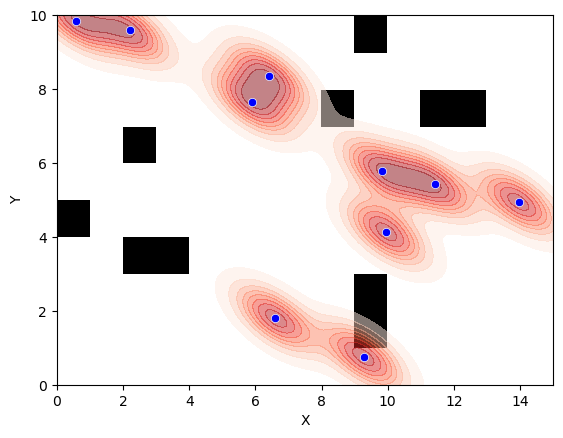

In [12]:
simul_clip_export('C:/Users/', result_df, space, 'contact_exper.mp4')